Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [16]:
import numpy as np
import gensim
import os
import re

# lda is in scikit learn but gensim is way better apparently
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [17]:

# Gensim - simple_preprocess
def tokenize(text):
    return [token for token in simple_preprocess(text) if token in STOPWORDS]
    #return gensim.utils.simple_preprocess(text)

In [18]:
test = "aha i know you are"
print(tokenize(test))

['you', 'are']


### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [19]:
path = './data/austen-brontë-split'

In [20]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            data.append(tokenize(str(text)))
            
    return data

In [21]:
tokens = gather_data(path)

In [22]:
tokens[0][0:10]

['very', 'too', 'and', 'her', 'was', 'all', 'in', 'at', 'his', 'was']

In [5]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [27]:
len(tokens)

813

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [23]:
titles = [t[:-4] for t in os.listdir(path)]

In [24]:
titles[:5]

['Austen_Sense0066',
 'Austen_Sense0005',
 'CBronte_Jane0122',
 'Austen_Sense0081',
 'CBronte_Professor0064']

In [25]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [26]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [28]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [29]:
df.head()

,tokens
Austen_Sense0066,"[very, too, and, her, was, all, in, at, his, w..."
Austen_Sense0005,"[you, call, them, you, have, from, been, more,..."
CBronte_Jane0122,"[you, as, as, you, and, all, you, have, to, sa..."
Austen_Sense0081,"[side, he, made, his, in, as, as, he, could, s..."
CBronte_Professor0064,"[to, the, under, his, and, when, he, had, it, ..."


In [30]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [31]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [32]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [35]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(str(text))
                yield tokens

In [36]:
streaming_data = doc_stream(path)

In [37]:
# gather_data => returns list
# doc_stream => returns generator
streaming_data # can only call on elements once

<generator object doc_stream at 0x7f96c86fa7c8>

In [95]:
next(streaming_data) # returns one doc at a time from generator

['long',
 'like',
 'hear',
 'reasonable',
 'unreasonable',
 'sat',
 'leave',
 'speak',
 'directly',
 'struggling',
 'tears',
 'time',
 'taken',
 'great',
 'pains',
 'repress',
 'knew',
 'like',
 'weep',
 'considered',
 'let',
 'flow',
 'freely',
 'long',
 'liked',
 'flood',
 'annoyed',
 'better',
 'gave',
 'way',
 'cried',
 'heartily',
 'soon',
 'heard',
 'earnestly',
 'entreating',
 'composed',
 'passion',
 'angry',
 'jane',
 'love',
 'steeled',
 'little',
 'pale',
 'face',
 'resolute',
 'frozen',
 'look',
 'endure',
 'hush',
 'wipe',
 'eyes',
 'softened',
 'voice',
 'announced',
 'subdued',
 'turn',
 'calm',
 'effort',
 'rest',
 'head',
 'shoulder',
 'permit',
 'draw',
 'jane',
 'jane',
 'accent',
 'bitter',
 'sadness',
 'thrilled',
 'nerve',
 'love',
 'station',
 'rank',
 'wife',
 'valued',
 'think',
 'disqualified',
 'husband',
 'recoil',
 'touch',
 'toad',
 'ape',
 'words',
 'cut',
 'ought',
 'probably',
 'tortured',
 'sense',
 'remorse',
 'hurting',
 'feelings',
 'control',
 'wis

### Gensim LDA Topic Modeling

In [94]:
doc_stream(path)

<generator object doc_stream at 0x7f9681de3408>

In [41]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [44]:
id2word.token2id['zoom']

KeyError: 'zoom'

Word 623^^^

In [45]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(161, 1), (1281, 3), (2473, 1), (9123, 1)]

doc 2 bag of words

In [46]:
import sys
sys.getsizeof(id2word)

56

In [47]:
len(id2word.keys())

22096

In [48]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [49]:
len(id2word.keys())

8103

This is countvectorize.transform vvv

In [50]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [51]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 2)]

NOW WE READY 4 LDA

In [52]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word, # dict not necessary for fitting of model but handy later on for visz
                   random_state=723812,
                   num_topics = 15,
                   passes=10, # it means the # of times I fit those distributions
                   workers=4
                  )

In [53]:
lda.print_topics()

[(0,
  '0.005*"paul" + 0.005*"little" + 0.004*"day" + 0.004*"good" + 0.004*"know" + 0.004*"man" + 0.004*"like" + 0.003*"thought" + 0.003*"night" + 0.003*"door"'),
 (1,
  '0.004*"wood" + 0.004*"helen" + 0.004*"look" + 0.004*"lowood" + 0.003*"liked" + 0.003*"long" + 0.003*"garden" + 0.003*"rochester" + 0.003*"trees" + 0.003*"like"'),
 (2,
  '0.016*"elizabeth" + 0.012*"bennet" + 0.011*"jane" + 0.009*"bingley" + 0.007*"miss" + 0.006*"collins" + 0.006*"soon" + 0.006*"dear" + 0.006*"know" + 0.006*"good"'),
 (3,
  '0.012*"darcy" + 0.012*"miss" + 0.011*"elizabeth" + 0.007*"little" + 0.006*"know" + 0.005*"room" + 0.005*"lady" + 0.005*"papa" + 0.005*"bretton" + 0.004*"think"'),
 (4,
  '0.014*"emma" + 0.012*"miss" + 0.008*"weston" + 0.007*"elton" + 0.007*"good" + 0.007*"thing" + 0.007*"little" + 0.007*"know" + 0.007*"think" + 0.007*"knightley"'),
 (5,
  '0.006*"adele" + 0.006*"little" + 0.005*"rochester" + 0.004*"monsieur" + 0.004*"away" + 0.004*"thought" + 0.004*"fairfax" + 0.004*"old" + 0.004*"

In [54]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [55]:
topics = [' '.join(t[0:5]) for t in words]

In [56]:
for t in topics: 
    print(t)
    print("\n")

paul little day good know


wood helen look lowood liked


elizabeth bennet jane bingley miss


darcy miss elizabeth little know


emma miss weston elton good


adele little rochester monsieur away


like little madame good time


rochester jane sir love know


bessie like little reed shall


little monsieur like day know


harriet think emma feelings time


old night time thought long


harriet knightley man smith having


elinor marianne sister edward mother


little room door graham thought




## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization reduce dimensions to visz

want our topics to be pretty evenly distributed

In [57]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [72]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.079713  0.019950       1        1  20.283566
4     -0.094380 -0.006981       2        1  15.480526
13    -0.123417  0.016243       3        1  12.932615
14     0.085740  0.076578       4        1   8.215403
7      0.022174  0.040770       5        1   8.179260
2     -0.168095  0.031187       6        1   7.686256
10    -0.156124 -0.036022       7        1   7.583149
9      0.049720  0.014354       8        1   6.754066
3     -0.077607  0.041586       9        1   5.207251
8      0.051198  0.071644      10        1   2.566450
0      0.069726  0.014599      11        1   2.537015
11     0.099639  0.010478      12        1   1.191390
5      0.063946 -0.012530      13        1   0.798426
12    -0.018317 -0.165238      14        1   0.315100
1      0.116085 -0.116617      15        1   0.269531, topic_info=     Category         Freq       Term        Total  loglift  logprob
1364  Default   511.000000    harriet   511.000000  30.0000  30.0000
1351  Default   853.000000       emma   853.000000  29.0000  29.0000
84    Default   656.000000     elinor   656.000000  28.0000  28.0000
2184  Default   620.000000  elizabeth   620.000000  27.0000  27.0000
155   Default   542.000000   marianne   542.000000  26.0000  26.0000
1377  Default   381.000000  knightley   381.000000  25.0000  25.0000
597   Default   938.000000       jane   938.000000  24.0000  24.0000
651   Default   367.000000  rochester   367.000000  23.0000  23.0000
2177  Default   394.000000      darcy   394.000000  22.0000  22.0000
406   Default  1714.000000     little  1714.000000  21.0000  21.0000
163   Default  1512.000000       miss  1512.000000  20.0000  20.0000
2257  Default   315.000000     bennet   315.000000  19.0000  19.0000
146   Default  1333.000000       like  1333.000000  18.0000  18.0000
609   Default   932.000000       long   932.000000  17.0000  17.0000
2024  Default   434.000000     weston   434.000000  16.0000  16.0000
1968  Default   381.000000      elton   381.000000  15.0000  15.0000
254   Default  1306.000000       time  1306.000000  14.0000  14.0000
613   Default   900.000000        man   900.000000  13.0000  13.0000
2258  Default   295.000000    bingley   295.000000  12.0000  12.0000
2548  Default   417.000000     madame   417.000000  11.0000  11.0000
225   Default   604.000000        sir   604.000000  10.0000  10.0000
1228  Default   273.000000   monsieur   273.000000   9.0000   9.0000
251   Default   782.000000      thing   782.000000   8.0000   8.0000
991   Default   624.000000      night   624.000000   7.0000   7.0000
624   Default   478.000000        old   478.000000   6.0000   6.0000
123   Default   651.000000      heart   651.000000   5.0000   5.0000
252   Default  1303.000000      think  1303.000000   4.0000   4.0000
562   Default   372.000000    fairfax   372.000000   3.0000   3.0000
814   Default  1141.000000    thought  1141.000000   2.0000   2.0000
226   Default   572.000000     sister   572.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1697  Topic15     1.222573     plants    18.491838   3.1999  -6.5383
2617  Topic15     1.583254      burns    31.354446   2.9304  -6.2798
6013  Topic15     1.280767      cigar    22.107349   3.0678  -6.4918
6211  Topic15     1.119483      sunny    17.167133   3.1861  -6.6264
2589  Topic15     2.516575      trees   108.719788   2.1504  -5.8163
2533  Topic15     1.282011        hay    23.721786   2.9983  -6.4908
2668  Topic15     2.011322       moon    73.918152   2.3121  -6.0404
2073  Topic15     1.866611        gay    64.157829   2.3790  -6.1151
602   Topic15     2.847415      liked   192.499847   1.7026  -5.6928
2965  Topic15     2.662673     garden   170.467041   1.7570  -5.7599
451   Topic15     1.866570       pure    68.294106   2.3165  -6.1151
364   Topic15     1.786840      fully    66.422455   2.3007  -6.1588
164

### Overall Model / Documents

In [64]:
lda[corpus[0]]

[(13, 0.99766076)]

In [65]:
distro = [lda[d] for d in corpus]

In [66]:
distro[0]

[(13, 0.99766076)]

In [67]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [71]:
len(new_distro)

813

In [68]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [69]:
df.head()

,paul little day good know,wood helen look lowood liked,elizabeth bennet jane bingley miss,darcy miss elizabeth little know,emma miss weston elton good,adele little rochester monsieur away,like little madame good time,rochester jane sir love know,bessie like little reed shall,little monsieur like day know,harriet think emma feelings time,old night time thought long,harriet knightley man smith having,elinor marianne sister edward mother,little room door graham thought,author
Austen_Sense0066,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.997661,0.0,Austen
Austen_Sense0005,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.230927,0.0,0.0,0.766906,0.0,Austen
CBronte_Jane0122,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.997146,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,CBronte
Austen_Sense0081,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.271070,0.0,0.0,0.726543,0.0,Austen
CBronte_Professor0064,0.0,0.0,0.0,0.0,0.0,0.0,0.997854,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,CBronte


In [70]:
df.groupby('author').mean()

,paul little day good know,wood helen look lowood liked,elizabeth bennet jane bingley miss,darcy miss elizabeth little know,emma miss weston elton good,adele little rochester monsieur away,like little madame good time,rochester jane sir love know,bessie like little reed shall,little monsieur like day know,harriet think emma feelings time,old night time thought long,harriet knightley man smith having,elinor marianne sister edward mother,little room door graham thought
author,,,,,,,,,,,,,,,
Austen,0.000345,0.000000,0.176966,0.076837,0.290293,0.000174,0.002889,0.001637,0.002277,0.001456,0.161805,0.002223,0.004615,0.275133,0.000801
CBronte,0.042828,0.004509,0.002314,0.034170,0.042144,0.013821,0.353372,0.158808,0.045397,0.116937,0.011556,0.018574,0.001795,0.006164,0.144944


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [76]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [ ]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=20, 
                                                        step=3,
                                                        passes=1);

In [79]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [80]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.640869,2,0
1,-0.767921,5,0
2,-0.822712,8,0
3,-0.740399,11,0
4,-0.765186,14,0


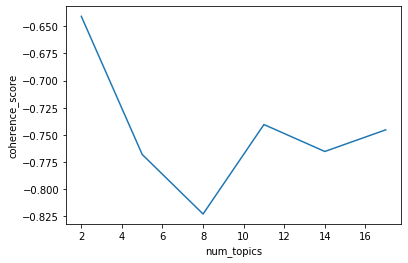

In [84]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [85]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [89]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.02226036),
 (1, 0.022260414),
 (2, 0.022260347),
 (3, 0.022260347),
 (4, 0.022260392),
 (5, 0.0222604),
 (6, 0.022260347),
 (7, 0.35487327),
 (8, 0.022260398),
 (9, 0.022260517),
 (10, 0.022260416),
 (11, 0.022260422),
 (12, 0.3557417),
 (13, 0.022260347),
 (14, 0.022260347)]

want highest coherence value possible

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [86]:
import spacy

nlp = spacy.load('en_core_web_lg')

/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [87]:
test = "Ned asked me a question about England today."

In [88]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [89]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [90]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [91]:
people = get_people(doc_stream(path))

In [92]:
doc = nlp(next(doc_stream(path)))

In [93]:
doc.ents[0].lemma_

'Morton'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)